In [3]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));
push!(LOAD_PATH, "src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
push!(LOAD_PATH, "../src");

In [3]:
#nbx --fname=../src/Pose2D.jl --jl_module=Pose2D
using Colors, Plots
col = palette(:default);
using MyUtils
import LinearAlgebra
using Base

"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
mutable struct Pose
    x::Vector{Float64}
    hd::Float64
end;

"""
    Conrol

Encoding the control of a 2d agent as a 
2d-velocity `dx` and its head direction change `dhd`.
"""
mutable struct Control
    dx::Vector{Float64}
    dhd::Float64
end;

Pose(x1, x2, hd)         = Pose([x1;x2],hd)
Pose(x::Vector{Float64}) = Pose(x[1:2], x[3])
Pose()                   = Pose([0;0], 0)
Base.Vector(p::Pose)     = [p.x;p.hd]

normalize_hd(hd::Real) = mod(hd + π, 2π) - π
function normalize!(p::Pose)
    p.hd = normalize_hd(p.hd)
    return p
end

headdirection(p::Pose) = p.hd
Base.angle(p::Pose)    = p.hd
MyUtils.rot(p::Pose)    = p.hd
position(p::Pose)      = p.x
tuple(p::Pose)         = (p.x, p.hd)

Base.iterate(p::Pose)             = iterate([p.x, p.hd])
Base.iterate(p::Pose, state::Int) = iterate([p.x, p.hd], state)
Base.getindex(p::Pose, i::Int)    = [p.x, p.hd][i]

Base.:(+)(p::Pose, x::Vector{Float64}) = Pose(p.x + x, p.hd)
Base.:(+)(p::Pose, hd::Float64) = Pose(p.x, p.hd + hd)
Base.:(+)(u::Control, v::Control) = Control(u.dx + v.dx, u.dhd + v.dhd)

Base.broadcastable(p::Pose) = [p]
LinearAlgebra.norm(p::Pose) = LinearAlgebra.norm(Vector(p))



Control(x1, x2, hd)         = Control([x1;x2],hd)
Control(x::Vector{Float64}) = Control(x[1:2], x[3])
Base.Vector(u::Control)     = [u.dx;u.dhd]

Base.:(+)(p::Pose, u::Control) = Pose(p.x + u.dx, p.hd + u.dhd)
Base.:(-)(p::Pose, u::Control) = Pose(p.x - u.dx, p.hd - u.dhd)


export Pose, Control, headdirection, position, tuple, normalize!, normalize_hd

In [12]:
#nbx
"""
    Mat(p::Pose)

Matrix representation of pose `p`. 
Transforms from pose's coordinates to global coordinates
"""
mat(p::Pose) = [rot(p.hd) p.x; [0 0 1]]

"""
    Inv(p::Pose)

Transforms into pose's ``egocentric'' coordinate system.
"""
inv(p::Pose) = Pose(-rot(-p.hd)*p.x, -p.hd)
export inv

# Syntactic sugar
Base.:(*)(x::Vector{Float64}, q::Pose) = rot( q.hd)*(x      ) + q.x
Base.:(/)(x::Vector{Float64}, q::Pose) = rot(-q.hd)*(x - q.x)

In [13]:
using LinearAlgebra: I

p = Pose(rand(2), rand()*2π)
x = rand(2)

isapprox(mat(p)*mat(inv(p)), I(3)),
isapprox(mat(p)*[x;1], [x*p;1]),
isapprox(mat(inv(p))*[x;1], [x/p;1])

(true, true, true)

In [14]:
x = [[0.0;0.0], [Inf,Inf]]
p = Pose(rand(2), rand()*2π)
x .* p
rot(p.hd)*x

2-element Vector{Vector{Float64}}:
 [-Inf, -Inf]
 [-Inf, -Inf]

In [15]:
#nbx
raw"""
    p/q

Interprets p and q in global coords and
returns p in q's coordinate system

On pose-matrix level this corresponds to
```
    Inv(q)*Mat(p)
```
"""
function Base.:(/)(p::Pose, q::Pose) 
    x  = rot(-q.hd)*(p.x - q.x)
    hd = p.hd - q.hd
    return Pose(x, hd)
end

raw"""
    p*q

Interprets p as given in q's coords and
returns its allocentric coords.

On pose-matrix level this corresponds to
```
    Mat(q)*Mat(p)
```
"""
function Base.:(*)(p::Pose, q::Pose) 
    x  = rot(q.hd)*(p.x) + q.x
    hd = p.hd + q.hd
    return Pose(x, hd)
end;



In [16]:
p = Pose(rand(2), rand()*2π)
q = Pose(rand(2), rand()*2π)

isapprox(mat(p/q), mat(inv(q))*mat(p), atol=1e-8),
isapprox(mat(p*q), mat(q)*mat(p), atol=1e-8),
isapprox((p/q*q).x , p.x , atol=1e-8),
isapprox((p/q*q).hd, p.hd, atol=1e-8)

(true, true, true, true)

In [72]:
#nbx
function Plots.plot!(p::Pose; r=0.5, arrow=false, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; arrow=arrow, r=r, args...)
end;

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, label=nothing, args...)
    myplot=nothing
    for (i,(p,c)) in enumerate(zip(ps,cs))
        if i > 1 label=nothing end
        myplot = plot!(p; c=c, r=r, label=label, args...)
    end
    return myplot
end;

function Plots.plot!(ps::Vector{Pose}; r=0.5, label=nothing, args...)
    myplot=nothing
    for (i,p) in enumerate(ps)
        if i > 1 label=nothing end
        myplot = plot!(p; label=label, r=r, args...)
    end
    return myplot
end;

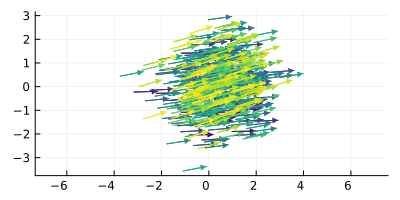

In [105]:
ps = [Pose(randn(2), rand()*2π/20) for i in 1:500]
zs = peak_to_peak(angle.(ps))
cs = cgrad(:viridis)[zs]
perm = sortperm(zs)
ps = ps[perm]
cs = cs[perm]

# -----------------
mypl = plot(size=(400,200), aspect_ratio=1.0)
plot!(ps,cs, r=1., arrow=:closed, linewidth=1)
mypl